# Start Code

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import json
import cv2
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create Torch Dataset

In [13]:
class KeypointsDataset(Dataset):
    def __init__(self, img_dir, data_file):
        self.img_dir = img_dir
        with open(data_file, "r") as f:
            self.data = json.load(f)
        self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((640, 640)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        img_name = item['file_upload'].split('-')[1]
        img = cv2.imread(f"{self.img_dir}/{img_name}")
        h,w = img.shape[:2]

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transforms(img)

        # Extract keypoints and convert from percentage to pixels
        kps_data = [ [ann['value']['x'] * w / 100, ann['value']['y'] * h / 100] 
                    for ann in item['annotations'][0]['result'] ]


        kps = np.array(kps_data).flatten()
        kps = kps.astype(np.float32)


        # Adjust keypoints from original resolution to 640x640
        kps[::2] *= 640.0 / w  # Adjust x coordinates
        kps[1::2] *= 640.0 / h  # Adjust y coordinates

        return img, kps
    



In [14]:
train_dataset = KeypointsDataset("line_crossing_dataset/data/images_cropped","line_crossing_dataset/data/data_cropped_train.json")
# val_dataset = KeypointsDataset("line_crossing_dataset/data/images","line_crossing_dataset/data/val.json")



In [15]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

# Create Model

In [16]:
model = models.resnet50(pretrained=True)
model.fc =  torch.nn.Linear(model.fc.in_features, 2*2) # Replaces the last layer

c:\Users\nikol\Documents\Projects\ai-camera\aicam-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikol\Documents\Projects\ai-camera\aicam-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
model = model.to(device)

# Train Model

In [18]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs=50
for epoch in range(epochs):
    for i, (imgs,kps) in enumerate(train_loader):
        imgs = imgs.to(device)
        kps = kps.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, kps)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch {epoch}, iter {i}, loss: {loss.item()}")

In [12]:
torch.save(model.state_dict(), "keypoints_model_cropped.pth")

# Inference

c:\Users\nikol\Documents\Projects\ai-camera\aicam-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikol\Documents\Projects\ai-camera\aicam-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


before rescale [214.73904 267.32858 583.70325 264.3346 ]
orig w 754 orig h 757
after rescale [252.98944 316.1996  687.6754  312.65826]


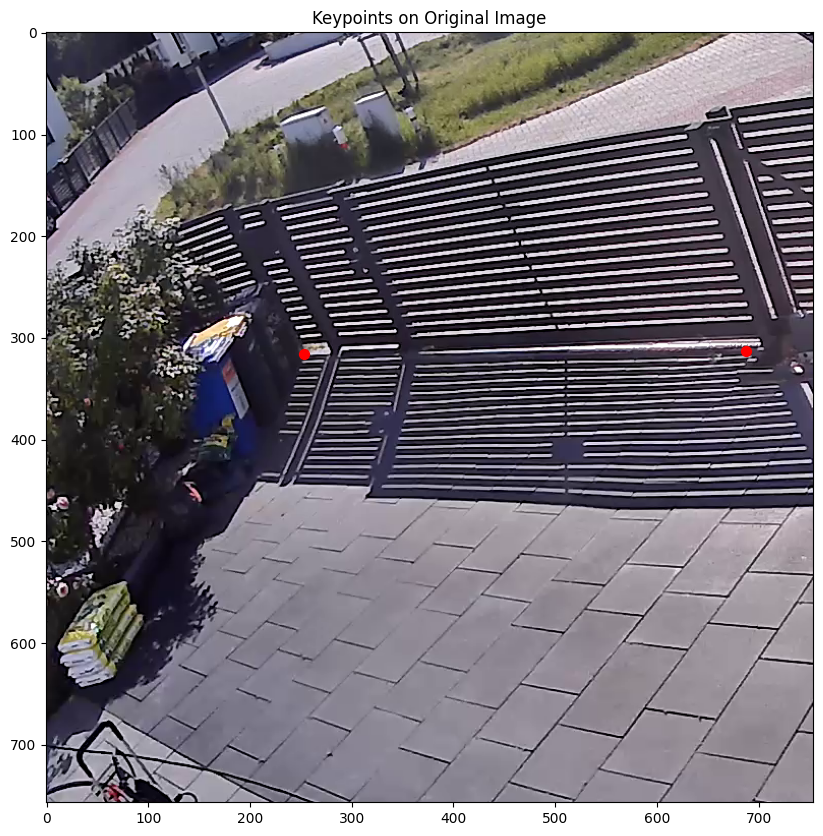

In [20]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 2*2) 
model.load_state_dict(torch.load('keypoints_model_cropped.pth', map_location=device))
model = model.to(device)
model.eval()

# Define the image transformations
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_and_plot(image_path):
    # Load the image
    img = cv2.imread(image_path)
    orig_h, orig_w = img.shape[:2]
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess the image
    input_tensor = preprocess(img_rgb).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(input_tensor)

    # Assuming the model outputs a single set of keypoints
    kps = outputs[0].cpu().numpy().flatten()

    print('before rescale', kps)
    print('orig w', orig_w, 'orig h', orig_h)

    # Convert keypoints from 640x640 back to original image dimensions
    kps[::2] *= orig_w / 640.0  # Rescale x coordinates
    kps[1::2] *= orig_h / 640.0 # Rescale y coordinates

    print('after rescale', kps)
    # Plot keypoints on the original image
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    for i in range(0, len(kps), 2):
        plt.scatter(kps[i], kps[i + 1], c='red', s=50)
    plt.title('Keypoints on Original Image')
    plt.show()

# Test the function
image_path = 'line_crossing_dataset/data/images_cropped/frame_1.png'
predict_and_plot(image_path)
